# Health Analytics Final Project : Twitter NLP

# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

import warnings
warnings.filterwarnings("ignore")

import io
from PIL import Image

# Read data

In [3]:
places = pd.read_csv('places.csv', index_col=0)
users = pd.read_csv('users.csv', index_col=0)
data = pd.read_csv('data.csv', index_col=0)

## 'Places' dataset

In [4]:
# overview of places dataset
print(places.shape)
places.head()

(1369, 8)


,country,country_code,full_name,geo.bbox,geo.type,id,name,place_type
0,United States,US,"Jefferson, VA","[-77.220862, 38.846423, -77.1548838, 38.879667]",Feature,604651199ea5b10a,Jefferson,city
1,United States,US,"Turlock, CA","[-120.912851, 37.459822, -120.812106, 37.53937]",Feature,ee2cfc9feb061a08,Turlock,city
2,United States,US,"Pennsylvania, USA","[-80.519851, 39.719801, -74.689517, 42.516072]",Feature,dd9c503d6c35364b,Pennsylvania,admin
3,United States,US,"Euclid, OH","[-81.552943, 41.5453355, -81.488014, 41.631584]",Feature,59ed3d5f720ebdf0,Euclid,city
4,United States,US,"Nashua, NH","[-71.5749, 42.7000873, -71.4333342, 42.805852]",Feature,db6cee8d55fe4a29,Nashua,city


In [5]:
# Find the number of unique data in the places dataset
places.nunique()

country          65
country_code     65
full_name       808
geo.bbox        810
geo.type          1
id              810
name            791
place_type        5
dtype: int64

In [6]:
# Find the number of unique country where people tweet and sort by frequency 
print(places.country_code.unique())
country_count = places.groupby('country').count()['id'].reset_index().sort_values(by='id',ascending=False)
country_count.style.background_gradient(cmap='Purples')

['US' 'BE' 'CA' 'IN' 'NG' 'TR' 'PA' 'GB' 'AU' 'GH' 'FJ' 'BD' 'GI' 'ID'
 'CL' 'SE' 'MY' 'LK' 'PT' 'PH' 'UG' 'JM' 'ZA' 'TT' 'SA' 'SG' 'VN' 'PK'
 'KR' 'NL' 'ES' 'SL' 'MX' 'BN' 'IE' 'BR' 'JP' 'IQ' 'EC' 'NZ' 'AG' 'SR'
 'FR' 'CD' 'MA' 'RU' 'AF' 'HK' 'IT' 'SO' 'GY' 'LC' 'BW' 'CF' 'CO' 'UY'
 'TH' 'HN' 'KE' 'TW' 'KW' 'AE' 'CY' 'MV' 'SZ']


,country,id
62,United States,720
61,United Kingdom,177
17,Ghana,81
8,Canada,63
37,Nigeria,61
22,India,52
2,Australia,22
48,South Africa,20
42,Republic of the Philippines,10
38,Pakistan,10


### Geospatial implementation

In [7]:
# extract latitude and longitude information from geo.bbox
places["geo.bbox"] = places["geo.bbox"].replace('\[','',regex=True)
places["geo.bbox"] = places["geo.bbox"].replace('\]','',regex=True)

geo_split = places["geo.bbox"].str.split(', ', n = 1, expand = True) 
lon = geo_split[[0]]
geo_split = geo_split[1].str.split(', ', n = 1, expand = True) 
lat = geo_split[[0]]

places['lat'] = lat
places['lon'] = lon  

In [8]:
places.head()

,country,country_code,full_name,geo.bbox,geo.type,id,name,place_type,lat,lon
0,United States,US,"Jefferson, VA","-77.220862, 38.846423, -77.1548838, 38.879667",Feature,604651199ea5b10a,Jefferson,city,38.846423,-77.220862
1,United States,US,"Turlock, CA","-120.912851, 37.459822, -120.812106, 37.53937",Feature,ee2cfc9feb061a08,Turlock,city,37.459822,-120.912851
2,United States,US,"Pennsylvania, USA","-80.519851, 39.719801, -74.689517, 42.516072",Feature,dd9c503d6c35364b,Pennsylvania,admin,39.719801,-80.519851
3,United States,US,"Euclid, OH","-81.552943, 41.5453355, -81.488014, 41.631584",Feature,59ed3d5f720ebdf0,Euclid,city,41.5453355,-81.552943
4,United States,US,"Nashua, NH","-71.5749, 42.7000873, -71.4333342, 42.805852",Feature,db6cee8d55fe4a29,Nashua,city,42.7000873,-71.5749


In [9]:
# draw the map
places_map = places.copy()
places_map = places_map.dropna()

lats = places_map['lat'].tolist()
lons = places_map['lon'].tolist()
locations = list(zip(lats, lons))

map_USA = folium.Map(location=[48, -102], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map_USA)
map_USA

In [12]:
map_USA.save("map.html")

## 'Users' dataset

In [161]:
# overview of users dataset
print(users.shape)
users.head()

(46152, 5)


,id,location,name,username,withheld.country_codes
0,1062523959097344000,United States,Dead Patriots Society🇺🇸,PatriotsDead,NaN
1,3981269773,"Minnesota, USA",Kale Glynn,Farm_Lift,NaN
2,1158127666253500417,GMT/UTC -6,hitt,Hitthere1,NaN
3,4766774253,Lagos Nigeria 🇳🇬,SimiSoFineSoFly 💎,simisanya,NaN
4,2236209360,NaN,Grant Hawley (no relation),HawleyGrant,NaN


In [164]:
# select useful data
users = users[['id', 'location','username']]
users = users.rename(columns={"id": "author_id", "location": "self_input_location"}, errors="raise")
print(users.nunique())
users.head()

author_id              38507
self_input_location    13633
username               38507
dtype: int64


,author_id,self_input_location,username
0,1062523959097344000,United States,PatriotsDead
1,3981269773,"Minnesota, USA",Farm_Lift
2,1158127666253500417,GMT/UTC -6,Hitthere1
3,4766774253,Lagos Nigeria 🇳🇬,simisanya
4,2236209360,NaN,HawleyGrant


## 'Data' dataset

In [165]:
# overview of data dataset
print(data.shape)
data.head()

(23838, 12)


,author_id,conversation_id,created_at,geo.coordinates.coordinates,geo.coordinates.type,geo.place_id,id,lang,possibly_sensitive,text,withheld.copyright,withheld.country_codes
0,1062523959097344000,1267244462801117190,2020-05-31T23:59:58.000Z,NaN,NaN,NaN,1267244462801117190,en,False,For another night of leftist funded social unr...,NaN,NaN
1,3981269773,1267219050997972992,2020-05-31T23:59:58.000Z,NaN,NaN,NaN,1267244462645936129,en,False,@SenatorSinema Not sure if you heard but Coron...,NaN,NaN
2,1158127666253500417,1267242925907460097,2020-05-31T23:59:58.000Z,NaN,NaN,NaN,1267244462201282560,en,False,@AzzyTheProtogen not only was he soldier in TF...,NaN,NaN
3,4766774253,1267210405664956417,2020-05-31T23:59:58.000Z,NaN,NaN,NaN,1267244462159380483,en,False,@kennedythacode Rightfully? You call that righ...,NaN,NaN
4,2236209360,1267237914842296320,2020-05-31T23:59:58.000Z,NaN,NaN,NaN,1267244461366693889,en,False,@dkm14 Yes. I know 4 people who have had it an...,NaN,NaN


In [13]:
# select useful part of the dataset
data = data[['id','author_id','created_at','lang','text']]
data = data.rename(columns={"id": "tweet_id", "lang": "language"}, errors="raise")
print(data.nunique())
data.head()

tweet_id      23838
author_id     19885
created_at     5099
language         10
text          23775
dtype: int64


,tweet_id,author_id,created_at,language,text
0,1267244462801117190,1062523959097344000,2020-05-31T23:59:58.000Z,en,For another night of leftist funded social unr...
1,1267244462645936129,3981269773,2020-05-31T23:59:58.000Z,en,@SenatorSinema Not sure if you heard but Coron...
2,1267244462201282560,1158127666253500417,2020-05-31T23:59:58.000Z,en,@AzzyTheProtogen not only was he soldier in TF...
3,1267244462159380483,4766774253,2020-05-31T23:59:58.000Z,en,@kennedythacode Rightfully? You call that righ...
4,1267244461366693889,2236209360,2020-05-31T23:59:58.000Z,en,@dkm14 Yes. I know 4 people who have had it an...


In [14]:
x = data.head().T
x

,0,1,2,3,4
tweet_id,1267244462801117190,1267244462645936129,1267244462201282560,1267244462159380483,1267244461366693889
author_id,1062523959097344000,3981269773,1158127666253500417,4766774253,2236209360
created_at,2020-05-31T23:59:58.000Z,2020-05-31T23:59:58.000Z,2020-05-31T23:59:58.000Z,2020-05-31T23:59:58.000Z,2020-05-31T23:59:58.000Z
language,en,en,en,en,en
text,For another night of leftist funded social unr...,@SenatorSinema Not sure if you heard but Coron...,@AzzyTheProtogen not only was he soldier in TF...,@kennedythacode Rightfully? You call that righ...,@dkm14 Yes. I know 4 people who have had it an...


In [169]:
# Find the number of unique language of tweets and sort by frequency  
lang_count = data.groupby('language').count()['tweet_id'].reset_index().sort_values(by='tweet_id',ascending=False)
lang_count.style.background_gradient(cmap='Purples')

,language,tweet_id
2,en,23803
9,tl,10
3,es,9
4,fr,5
7,pt,3
1,de,2
5,ht,2
6,in,2
0,da,1
8,sv,1


## Final data: merge the 'users' and 'data' dataset

In [177]:
df = data.merge(users,on='author_id', how='left')

In [178]:
print(df.shape)
df.nunique()

(51692, 7)


tweet_id               23838
author_id              19885
created_at              5099
language                  10
text                   23775
self_input_location     7594
username               19885
dtype: int64

In [181]:
# only keep the unique tweet_id and text
df = df.drop_duplicates(subset = ["text"])
print(df.shape)

(23775, 7)


In [182]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [183]:
# Find missing data
missing_data(df)

,tweet_id,author_id,created_at,language,text,self_input_location,username
Total,0,0,0,0,0,6551,0
Percent,0,0,0,0,0,27.5542,0
Types,int64,int64,object,object,object,object,object


In [184]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [185]:
# Find unique values
unique_values(df)

,tweet_id,author_id,created_at,language,text,self_input_location,username
Total,23775,23775,23775,23775,23775,17224,23775
Uniques,23775,19872,5095,10,23775,7591,19872


In [186]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [187]:
# Find most frequent values
most_frequent_values(df)

,tweet_id,author_id,created_at,language,text,self_input_location,username
Total,23775,23775,23775,23775,23775,17224,23775
Most frequent item,1267235523933827072,172663780,2020-05-31T23:00:00.000Z,en,@andymilonakis I hope when they return to Eart...,United States,stevetwilightim
Frequence,1,74,56,23740,1,411,74
Percent from total,0.004,0.311,0.236,99.853,0.004,2.386,0.311


In [188]:
# Set the bar graph
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
    else:
        g = sns.countplot(df[feature], palette='Set2')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 

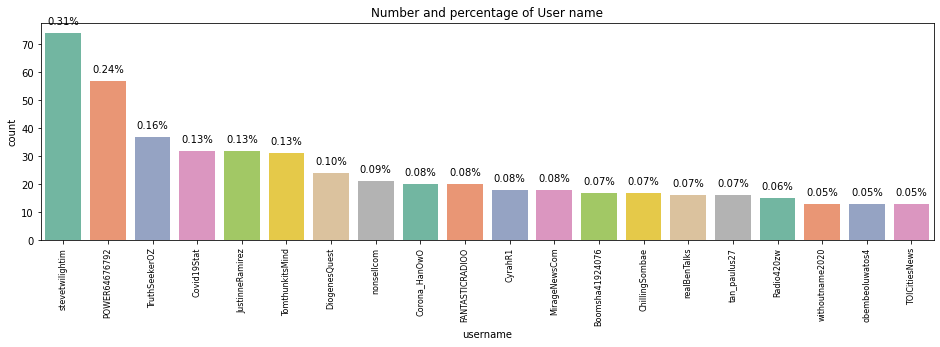

In [189]:
# Count the number and percentage of frequently tweeted user name 
plot_count("username", "User name", df, 4)

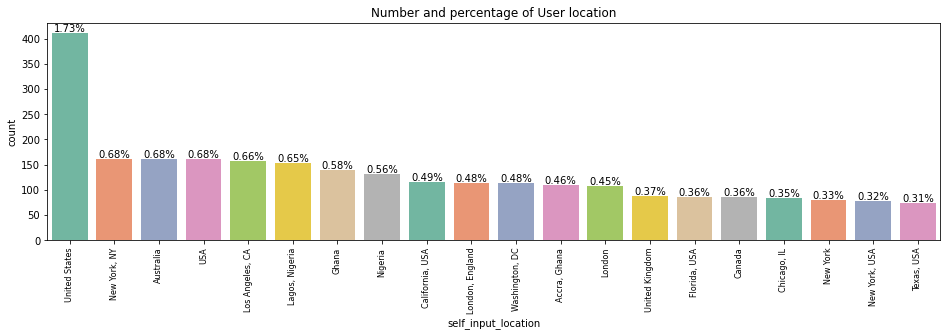

In [191]:
# Count the number and percentage of frequently tweeted user location 
plot_count("self_input_location", "User location", df, 4)

In [192]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

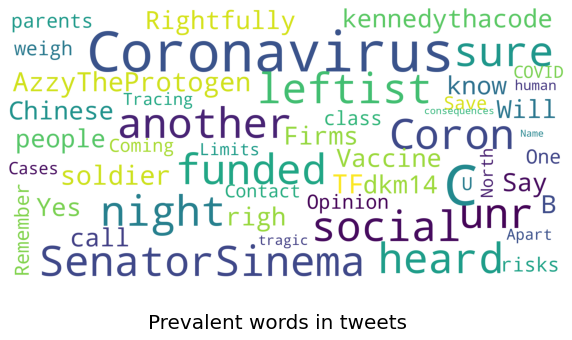

In [193]:
# Show the wordcloud of frequent tweets 
show_wordcloud(df['text'], title = 'Prevalent words in tweets')

In [195]:
# Datetime data
df['date'] = pd.to_datetime(df['created_at'])

In [196]:
# Since the data was collected on only a single day, we want to know the distribution of tweets by each hour and each minute
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

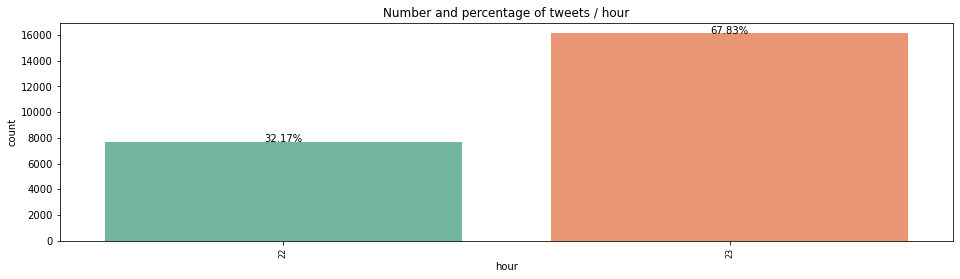

In [197]:
plot_count("hour", "tweets / hour", df,size=4, ordered=False)

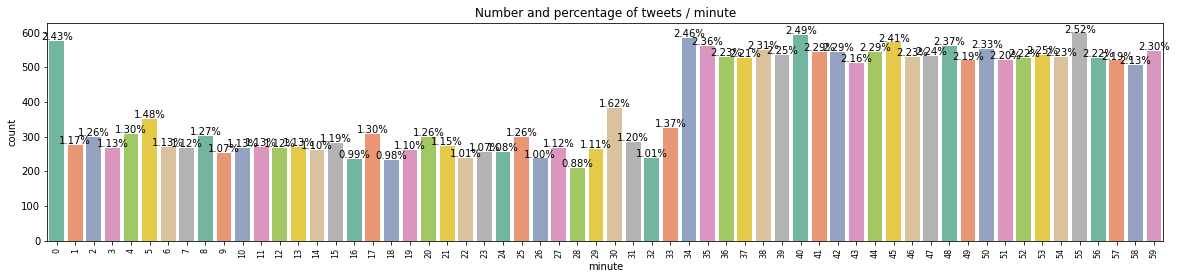

In [198]:
plot_count("minute", "tweets / minute", df,size=5, ordered=False)

In [200]:
df.head()

,tweet_id,author_id,created_at,language,text,self_input_location,username,date,hour,minute
0,1267244462801117190,1062523959097344000,2020-05-31T23:59:58.000Z,en,For another night of leftist funded social unr...,United States,PatriotsDead,2020-05-31 23:59:58+00:00,23,59
1,1267244462645936129,3981269773,2020-05-31T23:59:58.000Z,en,@SenatorSinema Not sure if you heard but Coron...,"Minnesota, USA",Farm_Lift,2020-05-31 23:59:58+00:00,23,59
2,1267244462201282560,1158127666253500417,2020-05-31T23:59:58.000Z,en,@AzzyTheProtogen not only was he soldier in TF...,GMT/UTC -6,Hitthere1,2020-05-31 23:59:58+00:00,23,59
3,1267244462159380483,4766774253,2020-05-31T23:59:58.000Z,en,@kennedythacode Rightfully? You call that righ...,Lagos Nigeria 🇳🇬,simisanya,2020-05-31 23:59:58+00:00,23,59
5,1267244461366693889,2236209360,2020-05-31T23:59:58.000Z,en,@dkm14 Yes. I know 4 people who have had it an...,NaN,HawleyGrant,2020-05-31 23:59:58+00:00,23,59
